In [1]:
#Importo la librerias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree

from sklearn.model_selection import train_test_split 
import sklearn

#conda install -c conda-forge hdbscan ##intalar HDBSCAN si no estuviera en el entorno 
import hdbscan

In [2]:
#importo el dataset y hago revision de los datos

df = pd.read_csv("titles_filtrado.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            5850 non-null   int64  
 1   id                    5850 non-null   object 
 2   title                 5849 non-null   object 
 3   type                  5850 non-null   object 
 4   description           5832 non-null   object 
 5   release_year          5850 non-null   int64  
 6   age_certification     3231 non-null   object 
 7   runtime               5850 non-null   int64  
 8   genres                5850 non-null   object 
 9   production_countries  5850 non-null   object 
 10  seasons               2106 non-null   float64
 11  imdb_id               5447 non-null   object 
 12  imdb_score            5850 non-null   float64
 13  imdb_votes            5352 non-null   float64
 14  tmdb_popularity       5759 non-null   float64
 15  tmdb_score           

In [3]:
# Drop de columnas innecesarias
df.drop("id", inplace=True, axis=1)

df.drop("imdb_id", inplace=True, axis=1)

# Limpio `genres` y `production_countries`, devuelta tomando el primer elemento de de la lista que cada valor retenga
def parse_list(row):
    parsed = str(row)[1:-1].split(",")
    for i in range(len(parsed)):
        parsed[i] = parsed[i].strip()[1:-1]
        
    return parsed[0] if parsed[0] != '' else 'N/A'

df['genres_parsed'] = df['genres'].map(parse_list)
df['prod_countries_parsed'] = df['production_countries'].map(parse_list)
df[['genres_parsed', 'prod_countries_parsed']]

,genres_parsed,prod_countries_parsed
0,documentation,US
1,drama,US
2,drama,US
3,fantasy,GB
4,war,GB
...,...,...
5845,romance,NG
5846,drama,N/A
5847,comedy,CO
5848,N/A,US


In [4]:
# Añado la columna 'is_movie'
df['is_movie'] = df.type.map(lambda x: 0 if x == 'SHOW' else 1)

In [5]:
# Obtengo todos los valores nulos
df.isnull().sum()

Unnamed: 0                  0
title                       1
type                        0
description                18
release_year                0
age_certification        2619
runtime                     0
genres                      0
production_countries        0
seasons                  3744
imdb_score                  0
imdb_votes                498
tmdb_popularity            91
tmdb_score                  0
genres_parsed               0
prod_countries_parsed       0
is_movie                    0
dtype: int64

In [6]:
# Drop de columnas innecesarias
df.drop("title", axis=1, inplace=True)
df.drop("description", axis=1, inplace=True)

# Relleno valores nulos
df['age_certification'].fillna("N/A", inplace=True)
df['seasons'].fillna(0.0, inplace=True)
df['tmdb_popularity'].fillna(df['tmdb_popularity'].mean(), inplace=True)
df['imdb_votes'].fillna(df['imdb_votes'].mean(), inplace=True)


# Confirmo que no queden valores nulos
df.isnull().sum()

Unnamed: 0               0
type                     0
release_year             0
age_certification        0
runtime                  0
genres                   0
production_countries     0
seasons                  0
imdb_score               0
imdb_votes               0
tmdb_popularity          0
tmdb_score               0
genres_parsed            0
prod_countries_parsed    0
is_movie                 0
dtype: int64

In [7]:
# Trasnfroma las variables categoricas en numericas
all_data = pd.get_dummies(df[[  'age_certification',
                                'genres_parsed', 
                                'prod_countries_parsed', 
                                'imdb_votes', 
                                'seasons', 
                                'is_movie',
                                'release_year',
                                'runtime']])



In [8]:
from sklearn.model_selection import train_test_split, cross_val_score

X = all_data.copy()
y = df.pop('imdb_score')




In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Creo las variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
#Entrenamiento del modelo
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [11]:
#Hacemos nuestras predicciones
y_pred = regressor.predict(X_test)

In [12]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
2089,7.0,6.831118
4909,5.6,5.888682
2961,5.8,6.079749
2070,5.9,6.195104
3054,7.3,7.396632
...,...,...
1771,8.5,7.526298
5636,5.5,6.306887
5557,6.4,6.071234
514,7.2,7.431180


Vemos que las predicciones son bastante acertadas.

In [13]:
regressor.score(X_test, y_test)

0.208232746127905

Pero mediante la funcion "score" nos da un puntaje de 20%

In [14]:
#Este es un metodo para ver el error en el modelo

from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def score_dataset(X_train, X_valid, y_train, y_valid, model=RandomForestRegressor(n_estimators=1000, random_state=0)):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return {"mean_squared_error": mean_squared_error(y_valid, preds), "mean_absolute_error": mean_absolute_error(y_valid, preds), "mean_absolute_percentage_error": mean_absolute_percentage_error(y_test, preds)}

In [15]:
scores = -1 * cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

score_dataset(X_train, X_test, y_train, y_test, model=LinearRegression())

{'mean_squared_error': 0.9789265316393205,
 'mean_absolute_error': 0.753050437310536,
 'mean_absolute_percentage_error': 0.13397723313893065}

# Recomendador de Producciones

In [2]:
df_titles = pd.read_csv("titles.csv") 

#Preparacion de datos para convertirlos a dummy/indicadores

df_titles['production_countries'] = df_titles['production_countries'].str.strip() #saco los espacios adelante y detras
df_titles['production_countries'] = df_titles['production_countries'].str.strip("[]") #saco los parentesis de la columna año
df_titles['production_countries'] = df_titles['production_countries'].str.split(expand=True)[0]#me quedo solo con el primer pais registrado
df_titles['production_countries'] = df_titles['production_countries'].str.strip(",")#saco una coma residual
#lo mismo para genero
df_titles['genres'] = df_titles['genres'].str.strip() #saco los espacios adelante y detras
df_titles['genres'] = df_titles['genres'].str.strip("[]") #saco los parentesis de la columna año
df_titles['genres'] = df_titles['genres'].str.split(expand=True)[0]#me quedo solo con el primer genero registrado
df_titles['genres'] = df_titles['genres'].str.strip(",") #saco una coma residual

df_titles.type = df_titles.type.replace({"SHOW": 1, "MOVIE": 0}) #convierto en 0 para serie y 1 para peliculas

#Relleno con ceros las peliculas que tienen valor de temporada NaN como defecto
values = {"seasons": 0}
df_titles.fillna(value=values, inplace= True) 

#descarto el resto de NaN

df_titles.dropna(inplace=True)  
# df.dropna(subset=['name', 'toy'])
df_titles.shape

(2904, 15)

In [3]:
#selecciono las features que iran al DF de entrenamiento
df_cluster = df_titles[['type',
                        'release_year',
                        'age_certification',
                        'runtime','genres',
                        'production_countries',
                        'seasons',
                        'imdb_votes',
                        'tmdb_popularity']]
df_cluster = pd.get_dummies(df_cluster) #realizo la conversion de object a indicadores(dummies)
df_cluster.head()

,type,release_year,runtime,seasons,imdb_votes,tmdb_popularity,age_certification_G,age_certification_NC-17,age_certification_PG,age_certification_PG-13,...,production_countries_'SG',production_countries_'SN',production_countries_'TH',production_countries_'TR',production_countries_'TW',production_countries_'UA',production_countries_'US',production_countries_'XX',production_countries_'ZA',production_countries_'ZW'
1,0,1976,114,0.0,808582.0,40.965,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1972,109,0.0,107673.0,10.010,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1975,91,0.0,534486.0,15.461,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1969,30,4.0,73424.0,17.617,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1979,94,0.0,395024.0,17.770,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# ALGORITMO HDBSCAN

In [4]:
#Instanciamos el algoritmo
clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                 min_samples=10,prediction_data=True)
                 
#Entrenamos
clusterer.fit(df_cluster)

HDBSCAN(min_cluster_size=20, min_samples=10, prediction_data=True)

In [5]:
print("Etiquetas de los clusters: ", np.unique(clusterer.labels_))
print("Cantidad de clusters: ", len(np.unique(clusterer.labels_)))

Etiquetas de los clusters:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32]
Cantidad de clusters:  34


### Como se puede ver se generan 34 Clusters diferentes, el cual el -1 es para identificar los outliers

## Prediccion de nuevos puntos

In [6]:
df_test24 = pd.read_excel('clusterdummy24.xlsx')#XLSX fitlrado con solo titulos de cluster 24

In [7]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, df_test24)
test_labels

array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24])

In [8]:
df_test317 = pd.read_excel('clusterdummy317.xlsx')#XLSX fitlrado con solo titulos de cluster 3 y de cluster 17

In [9]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, df_test317)
test_labels

array([ 3,  3,  3,  3, 17,  3,  3, 17, 17,  3,  3, 17,  3, 17, 17, 17,  3,
        3,  3,  3, 17,  3,  3,  3,  3,  3, 17,  3, 17,  3, 17, 17, 17, 17,
       17,  3, 17, 17,  3, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17,  3, 17, 17, 17,  3, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17])

## Grafico Sin outliers

In [10]:
df_clusterout = pd.read_excel('clusterdummyout.xlsx')#XLSX fitlrado sin outlier(cluster -1)

In [11]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, df_clusterout)
test_labels

array([ 7,  3,  7, ..., 29, 30, 29])

C:\Users\f.garciascorts\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='runtime', ylabel='imdb_votes'>

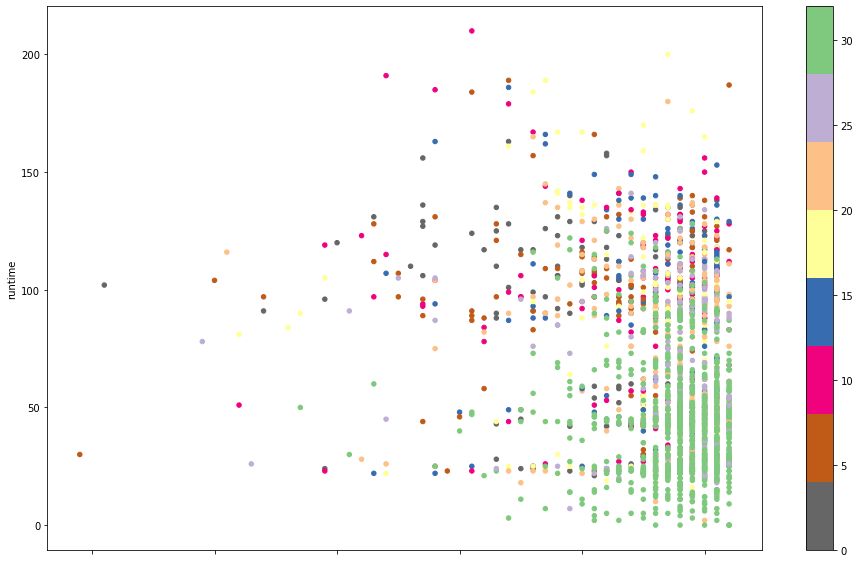

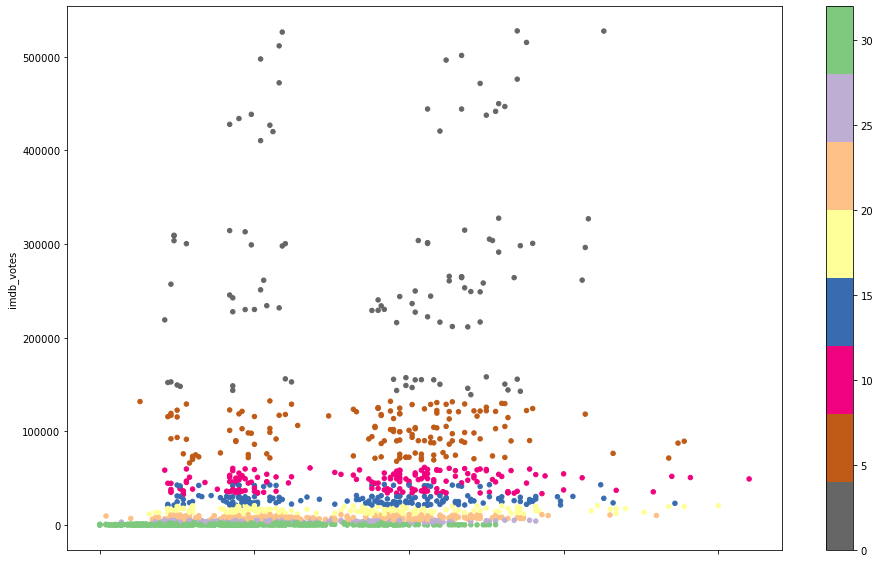

In [12]:
df_clusterout.plot(kind='scatter', x='release_year', y='runtime', c=test_labels, cmap='Accent_r', figsize=(16,10))
df_clusterout.plot(kind='scatter', x='runtime', y='imdb_votes', c=test_labels, cmap='Accent_r', figsize=(16,10))

## Grafico de outliers

C:\Users\f.garciascorts\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\f.garciascorts\Anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


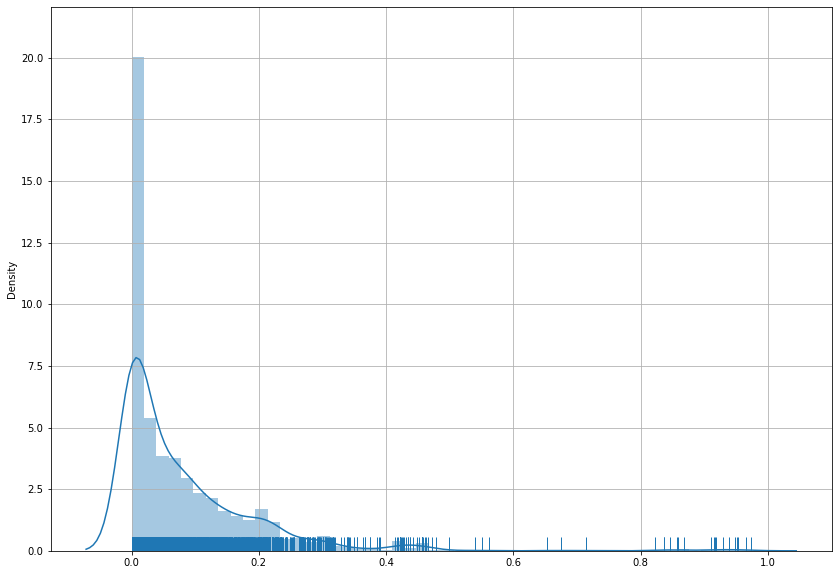

In [13]:
#grafico de outliers
plt.figure(figsize=(14, 10))
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)
plt.grid()
plt.show()